# Data Utility Learning

This notebooks introduces Data Utility Learning a method for improving the efficiency in computing Data Shapley values by learning to estimate the performance of a learning algorithm on unseen data combinations (i.e. subsets of the dataset). The method was described in the paper [Improving Cooperative Game Theory-Based Data Valuation Via Data Utility Learning](https://arxiv.org/pdf/2107.06336v2.pdf).

## Imports

In [1]:
%load_ext autoreload

In [2]:
%autoreload
import os
import random
from concurrent.futures import as_completed, ProcessPoolExecutor
from warnings import simplefilter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.neural_network import MLPRegressor
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.exceptions import ConvergenceWarning
from tqdm.auto import tqdm

from valuation.utils import Dataset, Utility, DataUtilityLearning, plot_shapley
from valuation.shapley import get_shapley_values

simplefilter("ignore", category=ConvergenceWarning)

In [3]:
plt.rcParams["figure.figsize"] = (18, 12)
plt.rcParams["font.size"] = 15
plt.rcParams["xtick.labelsize"] = 15
plt.rcParams["ytick.labelsize"] = 15

## Constants

In [4]:
random_state = 24

if os.environ.get("CI"):
    train_size = 5
    training_budget_values = np.arange(2, 10, 2)
    n_iterations = 1
else:
    train_size = 15
    training_budget_values = np.arange(100, 8000, 250)
    n_iterations = 10


mlp_kwargs = dict(
    hidden_layer_sizes=(20, 10),
    activation="relu",
    solver="adam",
    learning_rate_init=0.001,
    batch_size=32,
    max_iter=800,
)

In [5]:
random.seed(random_state)
np.random.seed(random_state)

## Dataset

Just like in the paper, we take 15 samples from the [Iris dataset](https://scikit-learn.org/stable/auto_examples/datasets/plot_iris_dataset.html) and compute their Data Shapley values by using all the remaining samples as test set for computing the utility, which in this case is accuracy.

In [6]:
X, y = load_iris(return_X_y=True)
x_train, x_test, y_train, y_test = train_test_split(
    X, y, train_size=train_size, random_state=random_state, stratify=y
)
dataset = Dataset(
    x_train=x_train,
    y_train=y_train,
    x_test=x_test,
    y_test=y_test
)

## Model

Also just like in the paper, we train fit a Support-Vector Classifier on the training data and we obtain an accuracy of around 92%

In [7]:
model = LinearSVC()
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
accuracy_score(y_test, y_pred)

0.9259259259259259

## Data Shapley

We start by defining the utility and computing the exact Data Shapley values

In [8]:
utility = Utility(
    model=LinearSVC(),
    data=dataset,
    enable_cache=False,
)

In [9]:
df = get_shapley_values(
    u=utility,
    mode="combinatorial_exact",
    progress=False,
)
df = df.set_index("data_key")
df = df.rename(columns={"shapley_dval": "exact"})

Then we compute the estimates of the Data Shapley values using the DataUtilityLearning wrapper which fits, just like in the paper, a Multi-Layer Perceptron (or Fully Connected Network) on a certain number, determined by `training_budget`, of utility samples (pairs of subset of training dataset and the corresponding utility).

In [10]:
for training_budget in tqdm(training_budget_values):
    
    def compute_shapley_values(utility: Utility, i: int):
        utility = DataUtilityLearning(
            u=utility,
            training_budget=training_budget,
            model=MLPRegressor(**mlp_kwargs)
        )

        dul_df = get_shapley_values(
            u=utility,
            mode="combinatorial_exact",
            progress=False,
        )
        dul_df = dul_df.set_index("data_key")
        dul_df = dul_df.rename(columns={"shapley_dval": f"{training_budget}_{i}"})
        return dul_df
    
    with ProcessPoolExecutor(4) as executor:
        futures = [executor.submit(compute_shapley_values, utility, i) for i in range(n_iterations)]
        for future in as_completed(futures, timeout=8 * 60):
            dul_df = future.result()
            df = pd.concat([df, dul_df], axis=1)

  0%|          | 0/32 [00:00<?, ?it/s]

After, we compute the mean, minimum and maximum $L_1$ error for the different training budget values and plots the results

In [11]:
errors = np.zeros((len(training_budget_values), n_iterations), dtype=float)

for i in range(len(training_budget_values)):
    for j in range(n_iterations):
        errors[i, j] = np.linalg.norm(df["exact"] - df[f"{training_budget_values[i]}_{j}"], ord=2)
        
error_from_mean = np.linalg.norm(df["exact"].values - df["exact"].values.mean(), ord=2)

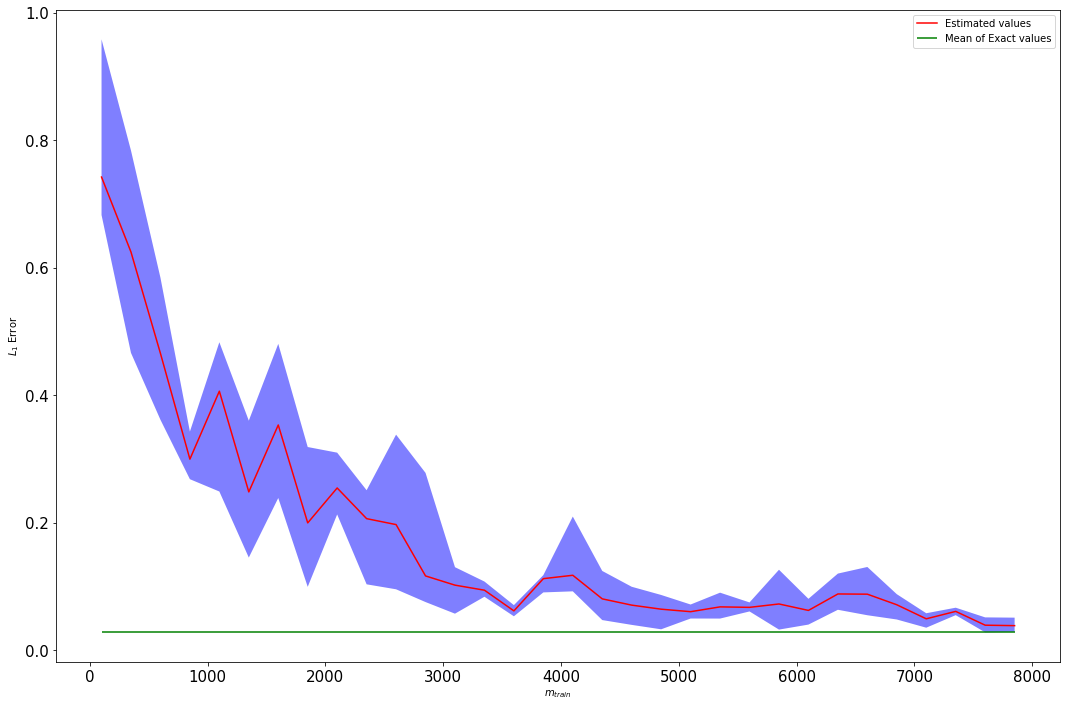

In [12]:
fig, ax = plt.subplots(figsize=(18, 12))
ax.plot(training_budget_values, errors.mean(axis=1), "r", label="Estimated values")
ax.hlines(error_from_mean, training_budget_values.min(), training_budget_values.max(), "g", label="Mean of Exact values")
ax.fill_between(training_budget_values, errors.min(axis=1), errors.max(axis=1), facecolor="blue", alpha=0.5)
ax.set_xlabel("$m_{train}$")
ax.set_ylabel("$L_1$ Error")
plt.legend()
plt.show()

As can be seen, the above plot matches the plots in the paper and thus shows that the method works for estimating the Data Shapley values.

In [13]:
best_training_budget = training_budget_values[errors.mean(axis=1).argmin()]

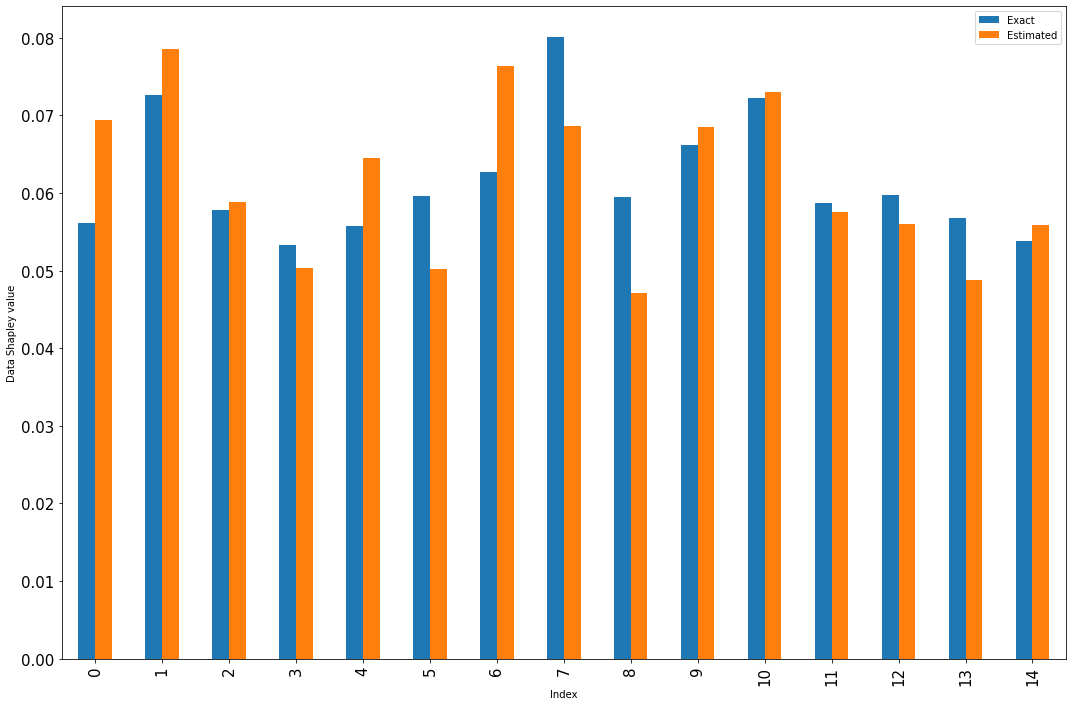

In [14]:
fig, ax = plt.subplots(figsize=(18, 12))
df.plot(y=["exact", f"{best_training_budget}_{0}"], kind="bar", ax=ax)
ax.set_xlabel("Index")
ax.set_ylabel("Data Shapley value")
plt.legend(["Exact", "Estimated"])
plt.show()

## Evaluation on anomalous data

One interesting way to assess the Data Utility Learning approach is to corrupt some of the data and monitor how the valuation score changes. To do this, we will take the sample with the highest score and change its label.

In [15]:
highest_value_index = df["exact"].argmax()
y_train_corrupted = dataset.y_train.copy()
y_train_corrupted[highest_value_index] = (y_train_corrupted[highest_value_index] + 1) % 3

corrupted_dataset = Dataset(
    x_train=dataset.x_train,
    y_train=y_train_corrupted,
    x_test=dataset.x_test,
    y_test=dataset.y_test
)

We retrain the model on the new dataset and notice that the accuracy decreased

In [16]:
model = LinearSVC()
model.fit(x_train, y_train_corrupted)
y_pred = model.predict(x_test)
accuracy_score(y_test, y_pred)

0.8296296296296296

After that, we recompute the scores of all samples using the exact method and the best training budget previously obtained and then plot the resulting scores.

In [17]:
utility = Utility(
    model=LinearSVC(),
    data=corrupted_dataset,
    enable_cache=False,
)

df_corrupted = get_shapley_values(
    u=utility,
    mode="combinatorial_exact",
    progress=False,
)
df_corrupted = df_corrupted.set_index("data_key")
df_corrupted = df_corrupted.rename(columns={"shapley_dval": "exact"})

utility = DataUtilityLearning(
    u=utility,
    training_budget=best_training_budget,
    model=MLPRegressor(**mlp_kwargs)
)

dul_df = get_shapley_values(
    u=utility,
    mode="combinatorial_exact",
    progress=False,
)
dul_df = dul_df.set_index("data_key")
dul_df = dul_df.rename(columns={"shapley_dval": "estimated"})
df_corrupted = pd.concat([df_corrupted, dul_df], axis=1)

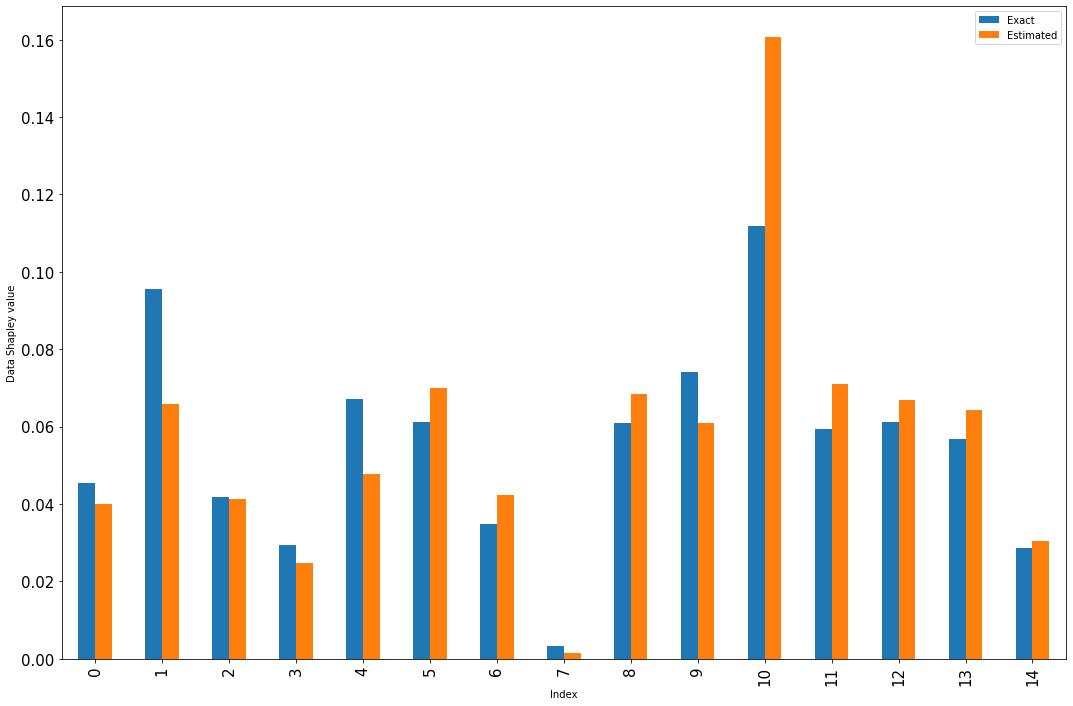

In [18]:
fig, ax = plt.subplots(figsize=(18, 12))
df_corrupted.plot(y=["exact", "estimated"], kind="bar", ax=ax)
ax.set_xlabel("Index")
ax.set_ylabel("Data Shapley value")
plt.legend(["Exact", "Estimated"])
plt.show()

As can be seen in the above figure, both the exact method and the approximate method agree on the fact that the sample with the corrupted label has the lowest value in the dataset.